In [1]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2024-05-07 13:35:53--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2024-05-07 13:35:53--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  22.2MB/s    in 3m 17s  

2024-05-07 13:39:11 (17.1 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [2]:
import  os,shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm
from PIL import Image
from skimage.transform import resize

from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau

In [3]:
!mkdir train_data
shutil.move('./DIV2K_train_HR.zip','./train_data')
os.chdir('./train_data')
!unzip DIV2K_train_HR.zip
os.chdir('./DIV2K_train_HR')

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_train_HR/0413.png  
  inflating: DIV2K_train_HR/0031.png  
  inflating: DIV2K_train_HR/0660.png  
  inflating: DIV2K_train_HR/0126.png  
  inflating: DIV2K_train_HR/0793.png  
  inflating: DIV2K_train_HR/0764.png  
  inflating: DIV2K_train_HR/0550.png  
  inflating: DIV2K_train_HR/0437.png  
  inflating: DIV2K_train_HR/0374.png  
  inflating: DIV2K_train_HR/0755.png  
  inflating: DIV2K_train_HR/0614.png  
  inflating: DIV2K_train_HR/0646.png  
  inflating: DIV2K_train_HR/0371.png  
  inflating: DIV2K_train_HR/0312.png  
  inflating: DIV2K_train_HR/0108.png  
  inflating: DIV2K_train_HR/0556.png  
  inflating: DIV2K_train_HR/0794.png  
  inflating: DIV2K_train_HR/0722.png  
  inflating: DIV2K_train_HR/0780.png  
  inflating: DIV2K_train_HR/0555.png  
  inflating: DIV2K_train_HR/0439.png  
  inflating: DIV2K_train_HR/0396.png  
  inflating: DIV2K_train_HR/0666.png  
  infl

In [4]:
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx,:]

In [5]:
img_list, img_low_list = [], []
for i in os.listdir():
  if '.png' in i:
    img = np.array(Image.open(i).convert("RGB"))
    img_crop = crop_center(img,224,224)
    img_list.append(img_crop)
    img_low_list.append(resize(img_crop,(56,56)))

high_reso_imgs = np.array(img_list)  # Convert list to NumPy array
low_reso_imgs = np.array(img_low_list)  # Convert list to NumPy array

In [6]:
os.chdir('/content')


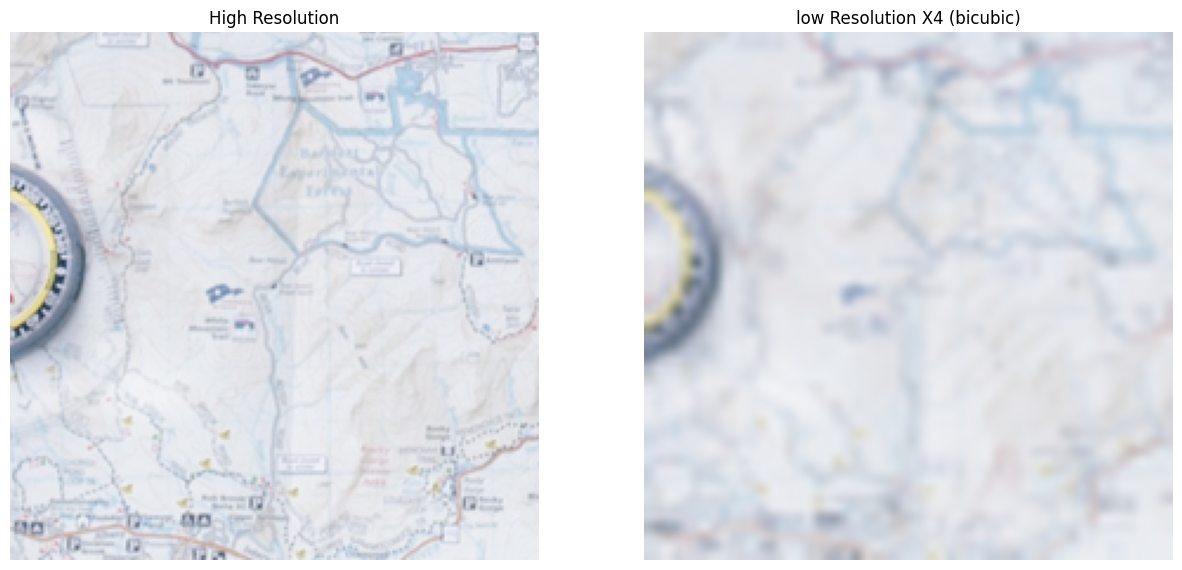

In [7]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(high_reso_imgs[2])
plt.grid('off')
plt.axis('off')
plt.title('High Resolution')
plt.subplot(1,2,2)
plt.imshow(cv2.resize(low_reso_imgs[2],(256,256),
                      interpolation = cv2.INTER_CUBIC))
plt.grid('off')
plt.axis('off')
_=plt.title('low Resolution X4 (bicubic)')

In [13]:
import tensorflow as tf

def edge_loss(y_true, y_pred):
    sobel_true = tf.image.sobel_edges(y_true)
    sobel_pred = tf.image.sobel_edges(y_pred)
    return tf.reduce_mean(tf.square(sobel_true - sobel_pred))

In [22]:
from keras.losses import MeanSquaredError, BinaryCrossentropy
from keras.applications.vgg19 import VGG19
from keras.models import Model

class SRGAN():
  # Implementation of SRGAN from paper:
  # https://arxiv.org/abs/1609.04802
    def __init__(self,lr_height = 64,lr_width = 64,channels = 3,
              upscale_factor = 4, generator_lr = 1e-4, discriminator_lr = 1e-4, gan_lr = 1e-4):
        self.height_low_reso = lr_height
        self.width_low_reso = lr_width

        if upscale_factor % 2 != 0:
            raise ValueError('Upscale factor is invalid, must be product of 2')

        self.upscale_factor = upscale_factor
        self.height_high_reso = self.height_low_reso * self.upscale_factor
        self.width_high_reso = self.width_low_reso * self.upscale_factor

        self.channels = channels
        self.shape_low_reso = (self.height_low_reso,self.width_low_reso,self.channels)
        self.shape_high_reso = (self.height_high_reso,self.width_high_reso,self.channels)

        self.samples = high_reso_imgs.shape[0]

        opti_generator = Adam(generator_lr,0.9)
        opti_discriminator = Adam(discriminator_lr,0.9)
        opti_gan = Adam(gan_lr,0.9)
        self.vgg = self.build_vgg()

        self.discriminator = self.build_discriminator(opti_discriminator)
        self.discriminator.trainable = False
        self.generator = self.build_generator(opti_generator)
        self.srgan = self.build_srgan(opti_gan)

    def save_GAN_Model(self,epoch):
        self.srgan.save_weights('srgan_weights_epoch_%d.h5' % epoch)


    def plotLosses(self,dlosses,glosses,epo):
        fig, ax1 = plt.subplots(figsize = (10,12))
        color = 'tab:blue'
        ax1.plot(dlosses,color = color, label = 'Dis loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Dis loss', color = color)
        ax1.tick_params('y',color = color)
        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.plot(glosses, color = color, label = 'Gen loss')
        ax2.set_ylabel('Gen loss', color = color)
        ax2.tick_params('y', color = color)
        plt.title('Discriminator & Generator Losses')
        plt.savefig('Losses_%d.png' % epo)
        plt.show()

    def gen_pipeline(self, batch_size = 16):
        while(1):
            indx_high = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)

            indx_low = np.random.randint(0,low_reso_imgs.shape[0]-1,batch_size)

            real = np.ones((batch_size,) + self.discriminator.output_shape[1:])

            fake = np.zeros((batch_size,) + self.discriminator.output_shape[1:])

            norm_hr = high_reso_imgs[indx_high]/127.5-1
            norm_lr = low_reso_imgs[indx_low]/127.5 -1
            yield(norm_hr,real,norm_lr,fake)

    def vgg_pipeline(self, batch_size = 16):
      while(1):
        indx = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
        real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
        norm_hr = high_reso_imgs[indx]/127.5-1
        norm_lr = low_reso_imgs[indx]/127.5 -1
        yield(norm_hr,norm_lr,real)


    def build_vgg(self):
        # Your existing code to set up the VGG model
        base_vgg = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=self.shape_high_reso))
        model_output = base_vgg.layers[9].output
        vgg_model = Model(inputs=base_vgg.inputs, outputs=model_output)
        vgg_model.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        return vgg_model

    def residual_block(self,input_layer):
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = PReLU()(x)
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Add()([input_layer,x])

    def disc_block(self,layer, n_filters, batch_norm = True):
        x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(layer)
        if batch_norm:
            x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters = n_filters, kernel_size = 3,
                   strides=2, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def Upsample_Block(self,x_in):
        x = Conv2D(filters = 256, kernel_size=3, padding='same')(x_in)
        x = self.SubpixelConv2D(2)(x)
        return PReLU()(x)

    def SubpixelConv2D(self,scale):
        return Lambda(lambda x: tf.nn.depth_to_space(x, scale))

    def build_generator(self,opti_generator,n_blocks = 16):
        input_layer = Input(self.shape_low_reso)

        first_layer = Conv2D(filters = 64, kernel_size = 9,
                             padding = 'same')(input_layer)

        first_layer = PReLU()(first_layer)

        residual_blocks = self.residual_block(first_layer)

        for _ in range(n_blocks-1):
            residual_blocks = self.residual_block(residual_blocks)

        output_residual = Conv2D(filters = 64, kernel_size = 3,
                             padding = 'same')(residual_blocks)

        output_residual = BatchNormalization(momentum=0.8)(output_residual)

        output_residual = Add()([output_residual,first_layer])

        upsample_layer = self.Upsample_Block(output_residual)

        for _ in range(self.upscale_factor//2-1):
            upsample_layer =  self.Upsample_Block(upsample_layer)

        gen_output = Conv2D(filters = 3, kernel_size = 9,
                            padding = 'same', activation = 'tanh')(upsample_layer)

        gen_model = Model(inputs = input_layer, outputs = gen_output)
        gen_model.compile(loss = 'binary_crossentropy', optimizer = opti_generator)

        return gen_model

    def build_discriminator(self,opti_discriminator,n_blocks = 3, n_filters = 64):
        input_layer = Input(self.shape_high_reso)
        discriminator_blocks = self.disc_block(input_layer,n_filters,False)
        for i in range(n_blocks):
            discriminator_blocks = self.disc_block(discriminator_blocks,
                                             n_filters = (i+1)*2*n_filters)

        #f_layer = GlobalAveragePooling2D()(discriminator_blocks)
        f_layer = Dense(units = 1024)(discriminator_blocks)
        f_layer = LeakyReLU(alpha=0.2)(f_layer)
        dis_output = Dense(units = 1, activation = 'sigmoid')(f_layer)
        disc_model = Model(inputs = input_layer, outputs = dis_output)
        disc_model.compile(loss = 'mse', optimizer = opti_discriminator,
                          metrics = ['accuracy'])

        return disc_model

    def build_srgan(self, optimizer):
        # Define inputs for the generator and discriminator
        dis_input = Input(shape=self.shape_high_reso)
        gen_input = Input(shape=self.shape_low_reso)

        # Generate high resolution outputs and features
        generated_high_reso = self.generator(gen_input)
        generated_features = self.vgg(generated_high_reso)
        generator_valid = self.discriminator(generated_high_reso)

        # Before integrating discriminator into the SRGAN model, set it to non-trainable
        self.discriminator.trainable = False
        for layer in self.discriminator.layers:
            layer.trainable = False

        # VGG is usually also set as non-trainable
        self.vgg.trainable = False
        for layer in self.vgg.layers:
            layer.trainable = False

        # Create the SRGAN model
        gan_model = Model(inputs=[gen_input, dis_input],
                          outputs=[generator_valid, generated_features])

        # Compile the SRGAN model
        gan_model.compile(loss=['binary_crossentropy', 'mse', edge_loss], loss_weights=[1e-3, 1, 0.1], optimizer=optimizer)
        gan_model.summary()

        return gan_model

    def train(self, epochs, save_interval = 100, batch_size = 16):
            pipeline = self.gen_pipeline(batch_size)
            vgg_pipeline = self.vgg_pipeline(batch_size)

            batch_count = self.samples // batch_size
            dlosses = []
            glosses = []
            for epo in range(1,epochs+1):
                print ('-'*15,'Epoch %d' % epo, '-'*15)
                for _ in tqdm(range(batch_count)):

                    ##########################

                    # Train the Discriminator

                    ##########################

                    # Generate Batch
                    hr_imgs, real, lr_imgs, fake = next(pipeline)

                    # Generate high resolution photos from low resolution photos
                    generated_hr_imags = self.generator.predict(lr_imgs)

                    # Train the discriminator
                    real_dis_loss = self.discriminator.train_on_batch(hr_imgs,real)
                    fake_dis_loss = self.discriminator.train_on_batch(generated_hr_imags,fake)
                    dis_loss = (0.5*np.add(real_dis_loss,fake_dis_loss))

                    ##########################

                    # Train the Generator

                    ##########################

                    #Generate Batch
                    hr_imgs, lr_imgs, real = next(vgg_pipeline)

                    # Extract ground truth using VGG model
                    img_features = self.vgg.predict(hr_imgs)

                    gan_loss = self.srgan.train_on_batch([lr_imgs,hr_imgs], [real, img_features])


                if epo % save_interval == 0:
                  self.save_GAN_Model(epo)
                  self.plotLosses(dlosses,glosses,epo)
                dlosses.append(gan_loss[1])
                glosses.append(gan_loss[0])
                print('\n',dlosses[-1],glosses[-1])

In [23]:
def plot_predict(low_reso_imgs,high_reso_imgs,srgan_model,n_imgs = 4):
    plt.figure(figsize = (12,12))
    plt.tight_layout()
    for i in range(0,n_imgs*3,3):
        idx = np.random.randint(0,low_reso_imgs.shape[0]-1)
        plt.subplot(n_imgs,3,i+1)
        plt.imshow(high_reso_imgs[idx])
        plt.grid('off')
        plt.axis('off')
        plt.title('Source')
        plt.subplot(n_imgs,3,i+2)
        plt.imshow(cv2.resize(low_reso_imgs[idx],(256,256),
                          interpolation = cv2.INTER_CUBIC))
        plt.grid('off')
        plt.axis('off')
        plt.title('X4 (bicubic)')

        img = srgan_model.generator.predict(np.expand_dims(low_reso_imgs[idx], axis = 0) / 127.5 - 1)
        img_unnorm = (img+1) * 127.5
        plt.subplot(n_imgs,3,i+3)
        plt.imshow(np.squeeze(img_unnorm, axis = 0).astype(np.uint8))
        plt.grid('off')
        plt.axis('off')
        plt.title('SRGAN')

    plt.savefig('predicted.png')

In [24]:
model_srgan = SRGAN(lr_height=56, lr_width=56, channels=3, upscale_factor=4)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 56, 56, 3)]          0         []                            
                                                                                                  
 model_12 (Functional)       (None, 224, 224, 3)          8979715   ['input_17[0][0]']            
                                                                                                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_11 (Functional)       (None, 14, 14, 1)            3759681   ['model_12[0][0]']            
                                                                                           

--------------- Epoch 1 ---------------


<ipython-input-22-37e950acec93>:203: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(batch_count)):


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 1s 810ms/step


1/1 [==============================] - 0s 27ms/step

 0.19548474252223969 55.71629333496094
--------------- Epoch 2 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 0.22557027637958527 50.12091064453125
--------------- Epoch 3 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

 0.18225708603858948 45.98746871948242
--------------- Epoch 4 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step

 0.18746253848075867 41.883907318115234
--------------- Epoch 5 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


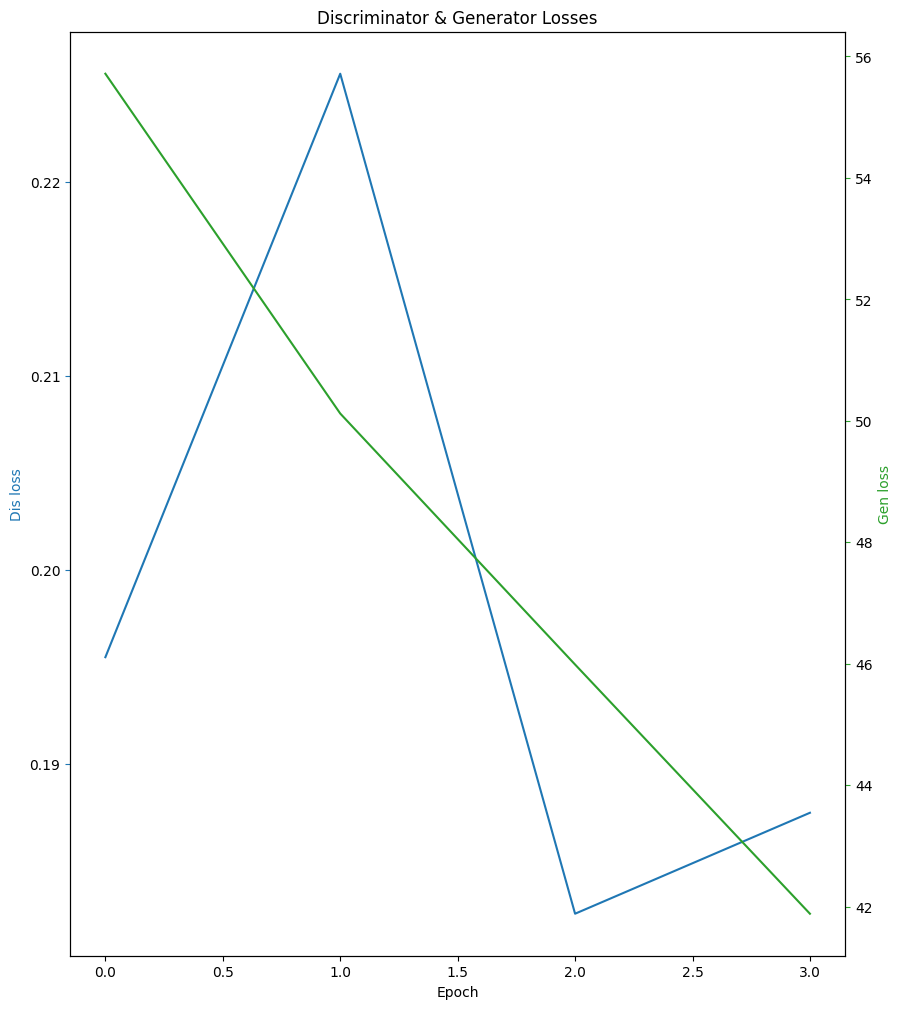


 0.16389352083206177 37.828590393066406
--------------- Epoch 6 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step

 0.2878934442996979 39.48928451538086
--------------- Epoch 7 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

 0.19822290539741516 49.00432205200195
--------------- Epoch 8 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

 0.25857213139533997 48.91473388671875
--------------- Epoch 9 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 0.3270846903324127 39.950653076171875
--------------- Epoch 10 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


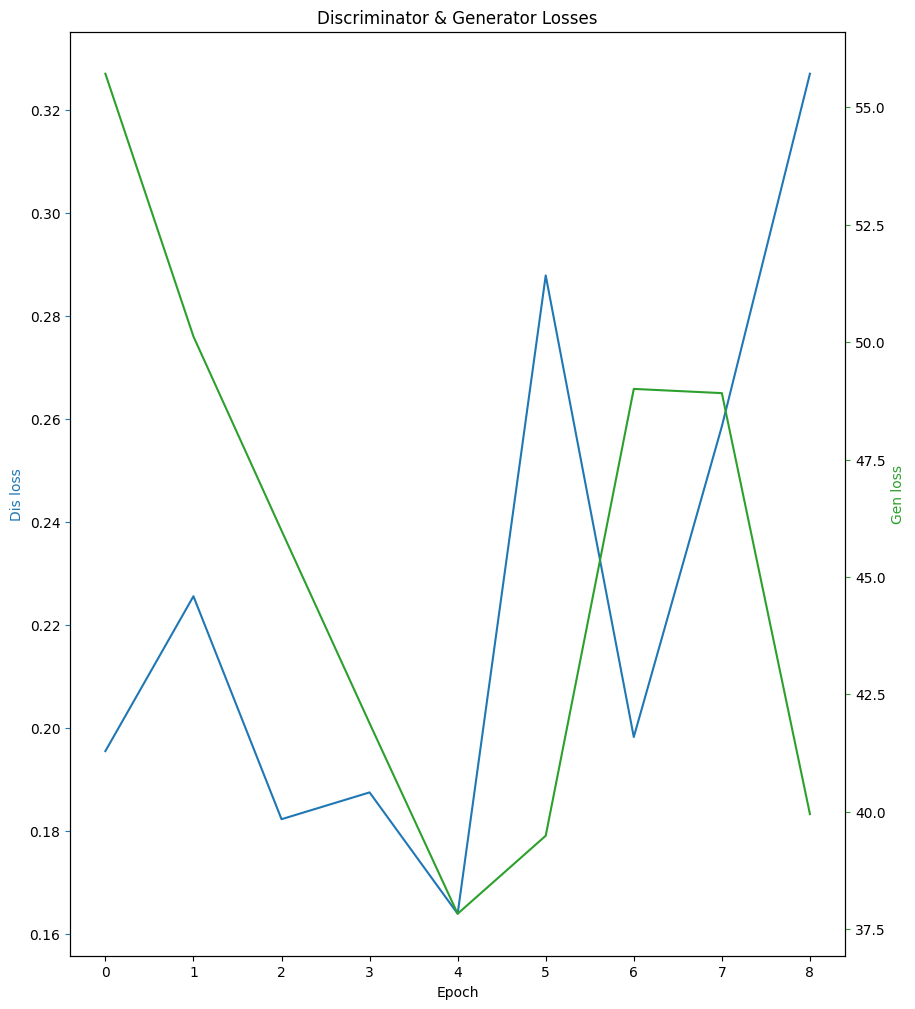


 0.4999520778656006 56.01081466674805
--------------- Epoch 11 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

 0.5774950981140137 42.41655349731445
--------------- Epoch 12 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step

 0.7352378368377686 38.574241638183594
--------------- Epoch 13 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step

 1.513556957244873 40.6757926940918
--------------- Epoch 14 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 1.3512762784957886 42.52822494506836
--------------- Epoch 15 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


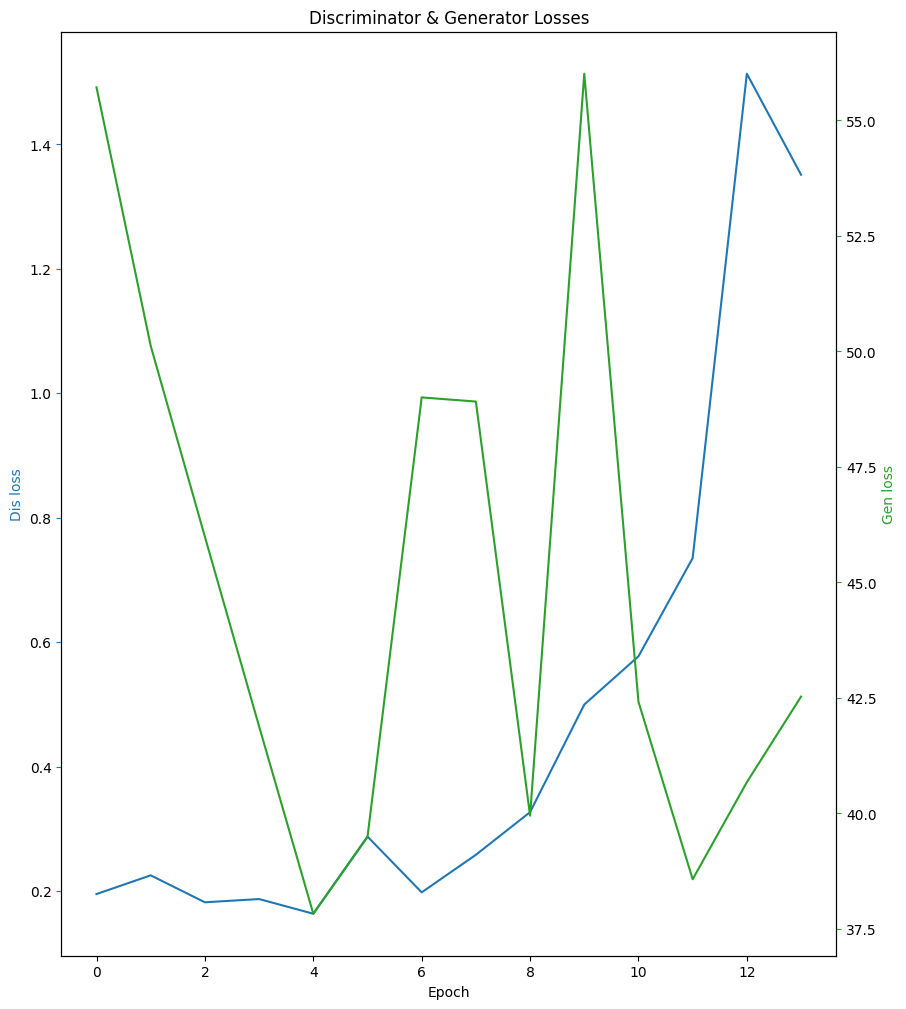


 1.1912751197814941 39.31483459472656
--------------- Epoch 16 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 2.1625499725341797 44.456398010253906
--------------- Epoch 17 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 2.5356810092926025 36.7984733581543
--------------- Epoch 18 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

 2.0366008281707764 41.78464889526367
--------------- Epoch 19 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 2.2409844398498535 39.3902587890625
--------------- Epoch 20 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


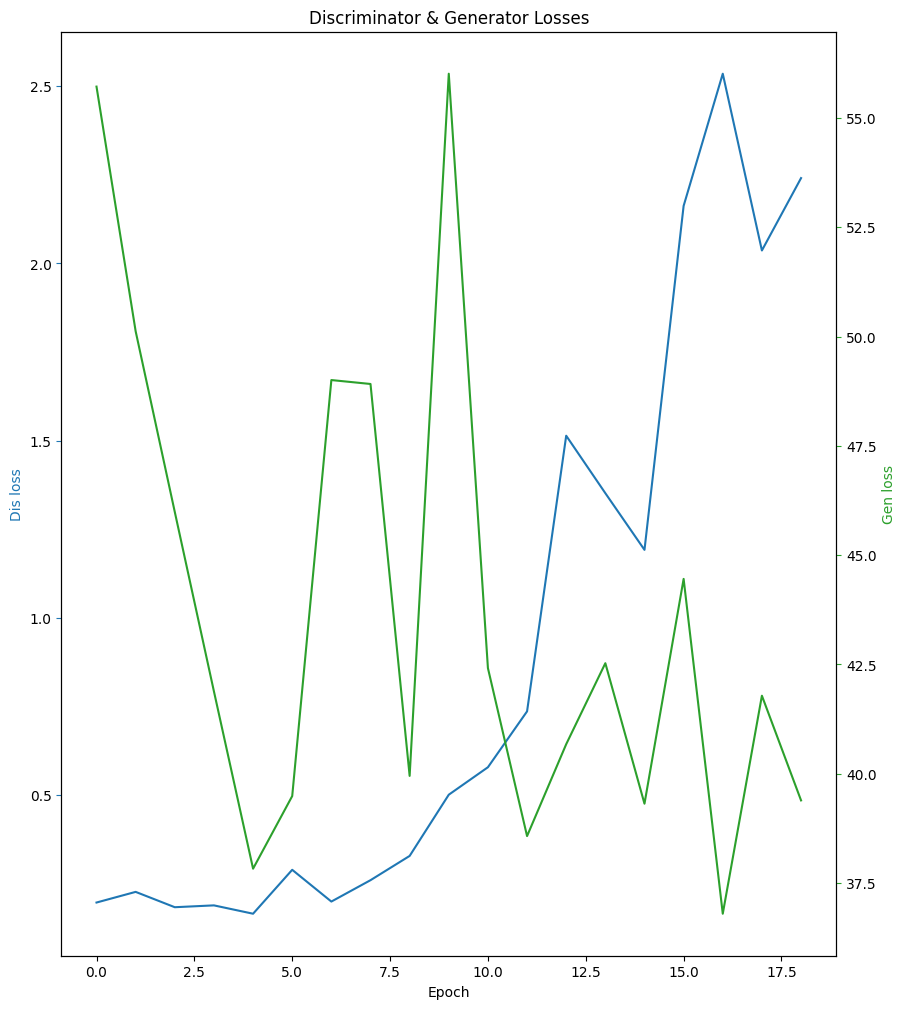


 2.826840877532959 44.4296760559082
--------------- Epoch 21 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 2.2899458408355713 36.92341995239258
--------------- Epoch 22 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 2.4176950454711914 35.28947448730469
--------------- Epoch 23 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step

 2.593794107437134 37.88288879394531
--------------- Epoch 24 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 2.751131534576416 30.035165786743164
--------------- Epoch 25 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


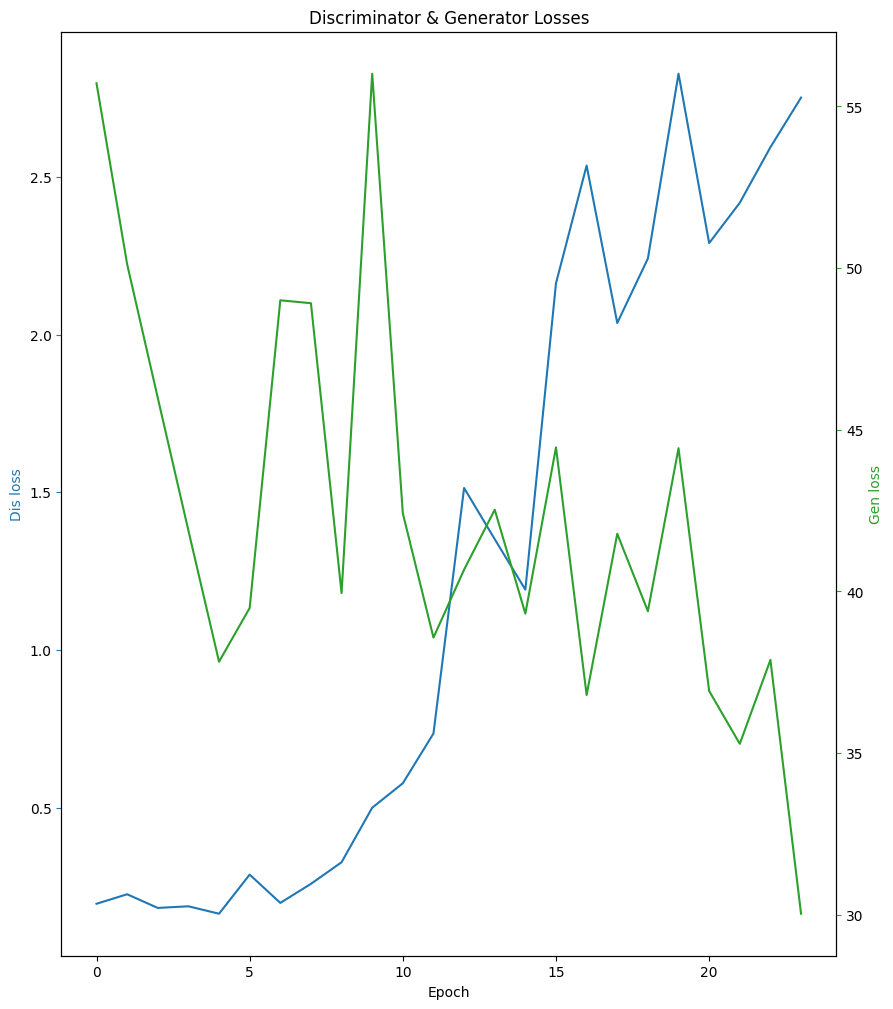


 2.7279915809631348 31.960769653320312
--------------- Epoch 26 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 2.6842617988586426 30.98972511291504
--------------- Epoch 27 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step

 2.4703588485717773 25.11813735961914
--------------- Epoch 28 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 3.133043050765991 25.043432235717773
--------------- Epoch 29 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 2.564671516418457 31.89223861694336
--------------- Epoch 30 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


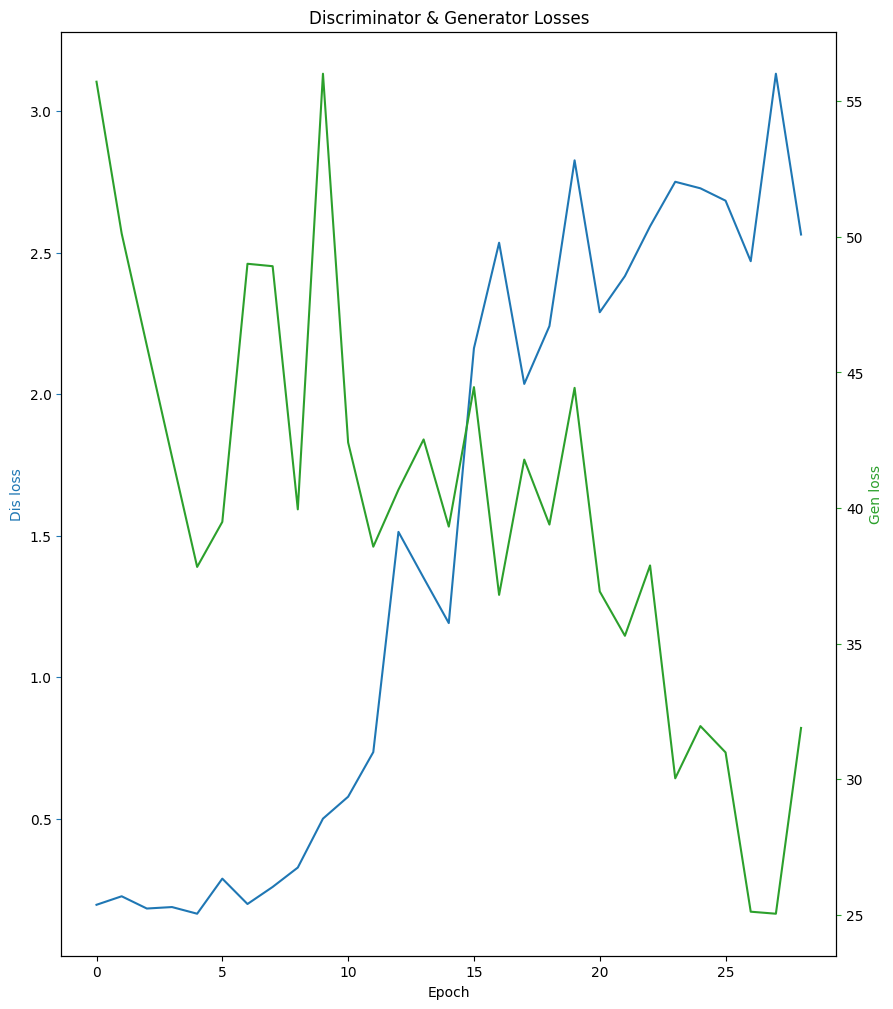


 2.9298744201660156 22.74240493774414
--------------- Epoch 31 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 2.8996224403381348 30.222625732421875
--------------- Epoch 32 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 2.599684476852417 34.32741928100586
--------------- Epoch 33 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step

 2.8857462406158447 27.575592041015625
--------------- Epoch 34 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step

 1.6434270143508911 27.394441604614258
--------------- Epoch 35 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


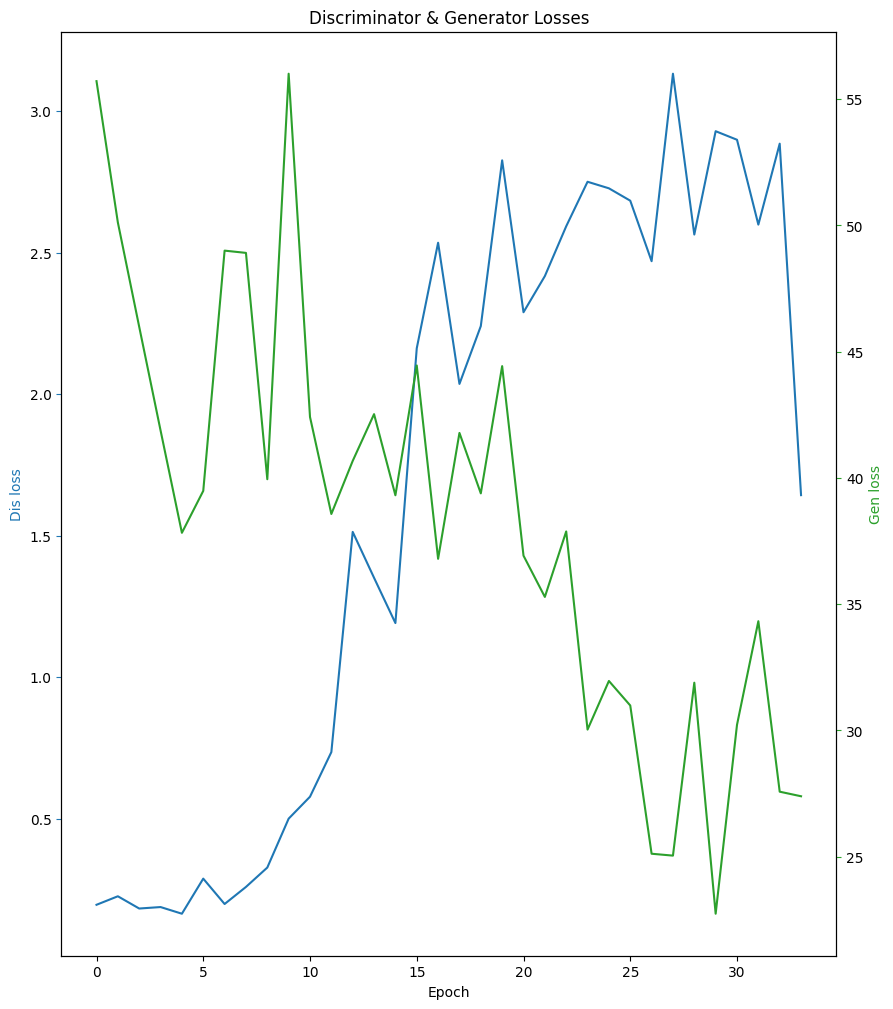


 2.3254005908966064 25.32453155517578
--------------- Epoch 36 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 2.5229127407073975 24.919931411743164
--------------- Epoch 37 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step

 1.6849013566970825 23.926254272460938
--------------- Epoch 38 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step

 2.294034957885742 24.583553314208984
--------------- Epoch 39 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 1.5146691799163818 32.7895622253418
--------------- Epoch 40 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


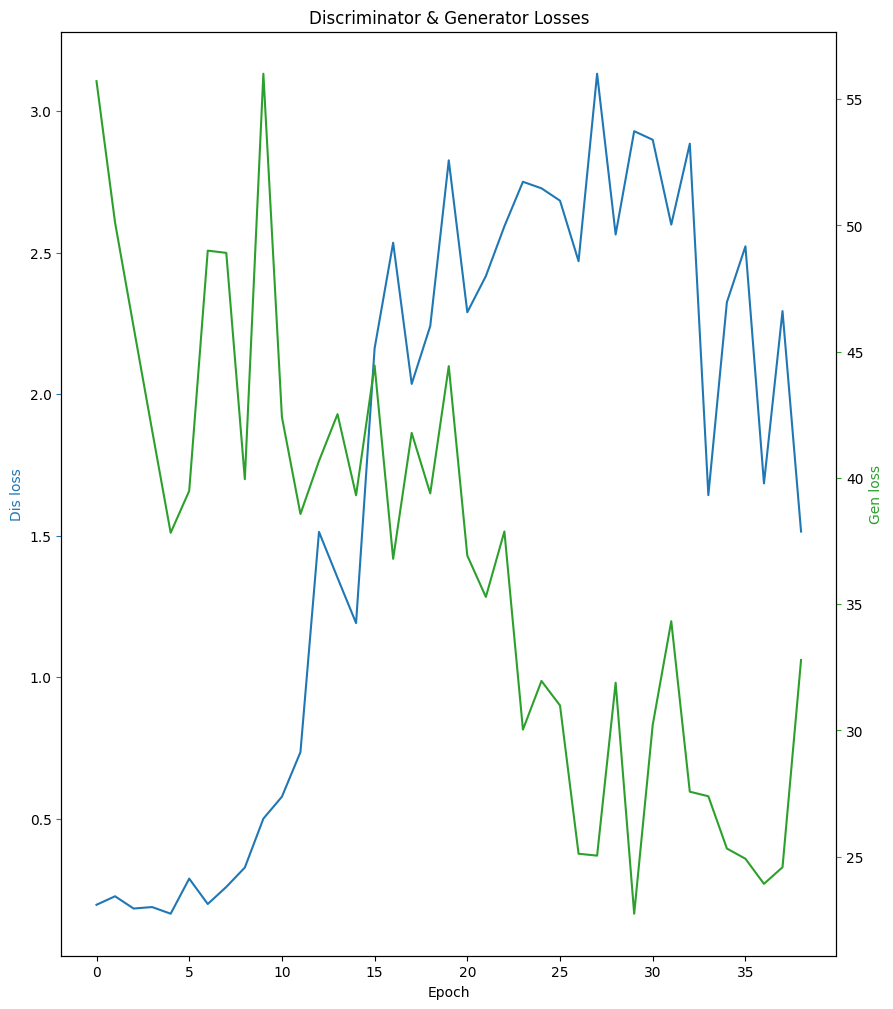


 1.7829234600067139 23.618656158447266
--------------- Epoch 41 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 1.2775392532348633 21.146406173706055
--------------- Epoch 42 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 1.7837601900100708 28.119075775146484
--------------- Epoch 43 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step

 1.2219163179397583 23.784793853759766
--------------- Epoch 44 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 1.8583810329437256 19.821985244750977
--------------- Epoch 45 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


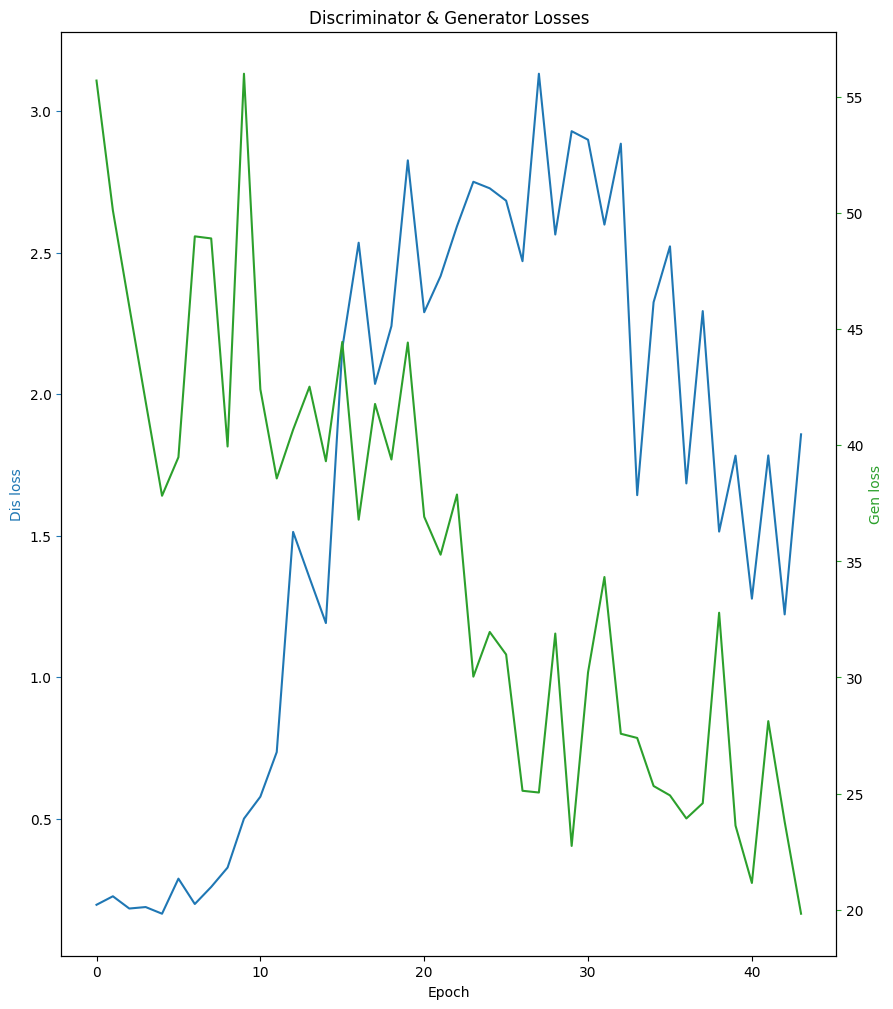


 1.929997444152832 25.317285537719727
--------------- Epoch 46 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 1.5969412326812744 23.687332153320312
--------------- Epoch 47 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step

 1.9269614219665527 22.179500579833984
--------------- Epoch 48 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step

 1.7417051792144775 17.325822830200195
--------------- Epoch 49 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step

 0.8570063710212708 25.791528701782227
--------------- Epoch 50 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


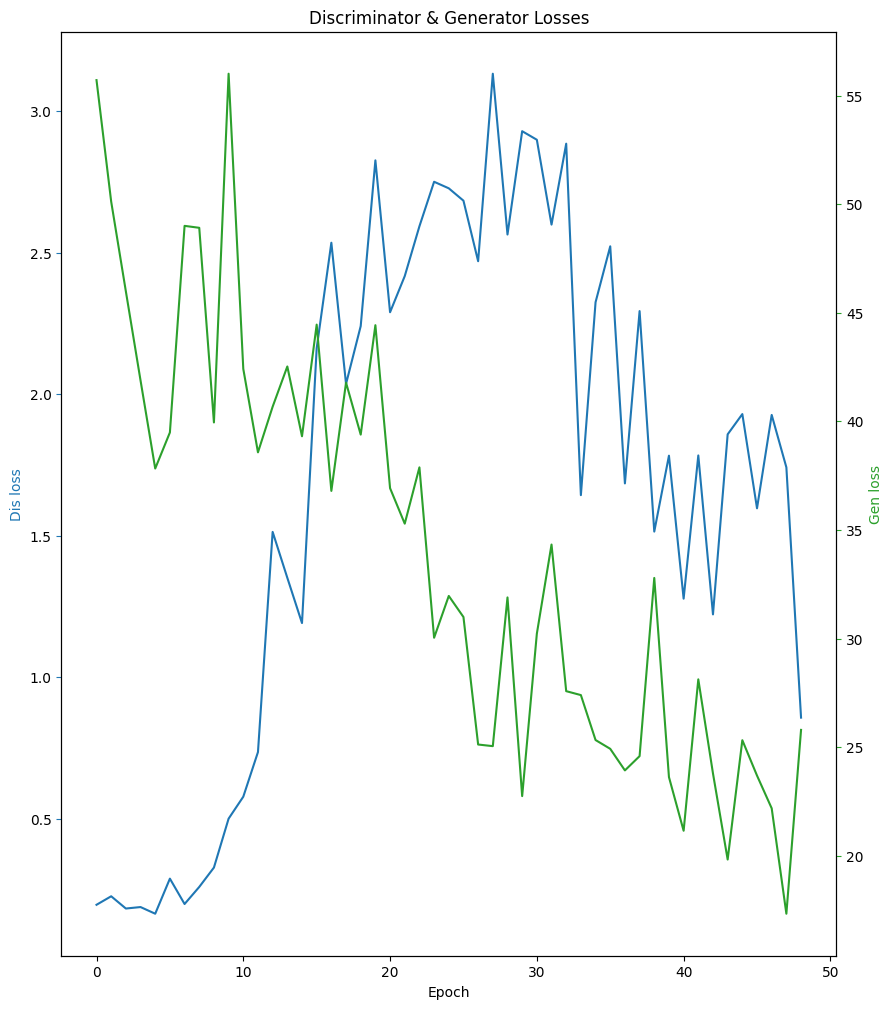


 1.5940521955490112 20.303936004638672


In [25]:
model_srgan.train(epochs=50, save_interval=5, batch_size=16)

In [26]:
model_srgan.generator.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 56, 56, 3)]          0         []                            
                                                                                                  
 conv2d_137 (Conv2D)         (None, 56, 56, 64)           15616     ['input_15[0][0]']            
                                                                                                  
 p_re_lu_55 (PReLU)          (None, 56, 56, 64)           200704    ['conv2d_137[0][0]']          
                                                                                                  
 conv2d_138 (Conv2D)         (None, 56, 56, 64)           36928     ['p_re_lu_55[0][0]']          
                                                                                           

In [27]:
model_srgan.discriminator.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_129 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 224, 224, 64)      0         
                                                                 
 conv2d_130 (Conv2D)         (None, 112, 112, 64)      36928     
                                                                 
 batch_normalization_80 (Ba  (None, 112, 112, 64)      256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 112, 112, 64)      0         
                                                          

1/1 [==============================] - 1s 692ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


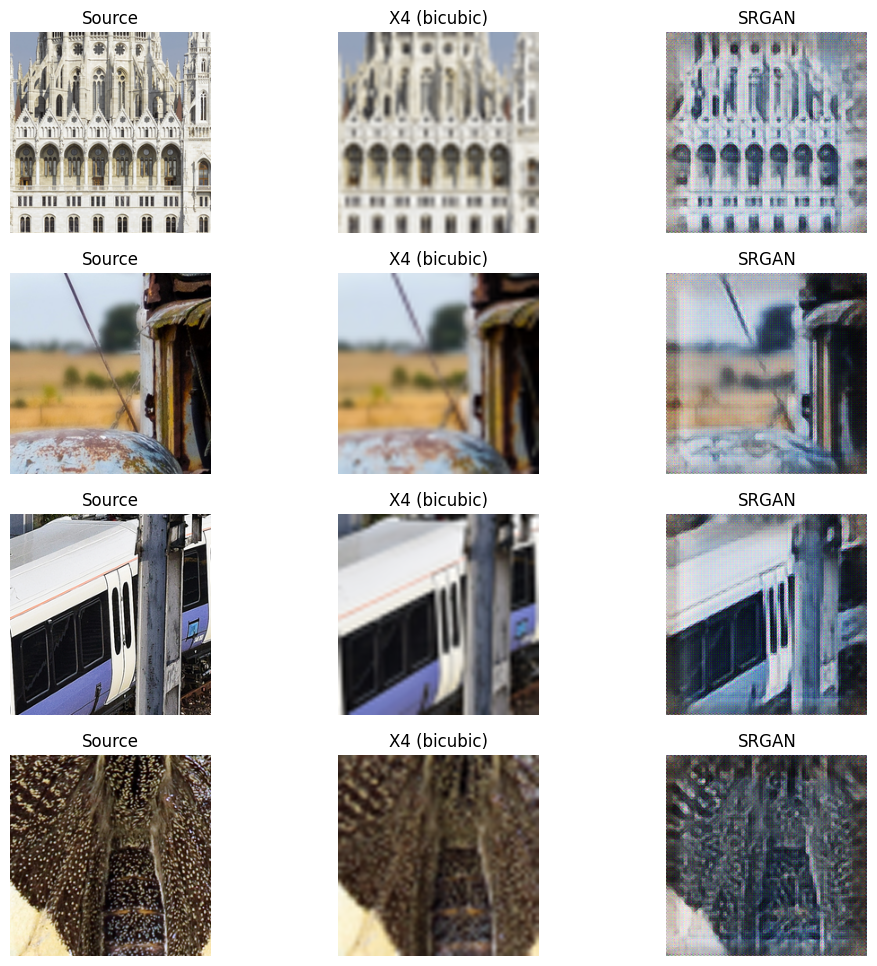

In [28]:
plot_predict(low_reso_imgs, high_reso_imgs, model_srgan, n_imgs=4)

In [29]:
os.chdir('/content')
!mkdir training_process
os.chdir('./training_process')

In [31]:
shutil.move('/content/srgan_weights_epoch_50.h5', os.getcwd())

'/content/training_process/srgan_weights_epoch_50.h5'

--------------- Epoch 1 ---------------


<ipython-input-22-37e950acec93>:203: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(batch_count)):


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step

 1.8539485931396484 17.579477310180664
--------------- Epoch 2 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 1.6389602422714233 22.47271728515625
--------------- Epoch 3 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

 16.215675354003906 21.553773880004883
--------------- Epoch 4 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 4.953010559082031 23.743682861328125
--------------- Epoch 5 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 4.4757585525512695 19.01422691345215
--------------- Epoch 6 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 3.864471435546875 18.000219345092773
--------------- Epoch 7 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 4.177247524261475 19.23694610595703
--------------- Epoch 8 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 3.861387252807617 16.53738784790039
--------------- Epoch 9 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step

 4.258367538452148 19.718557357788086
--------------- Epoch 10 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step

 4.051372528076172 16.809043884277344
--------------- Epoch 11 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 3.9614803791046143 22.253877639770508
--------------- Epoch 12 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 4.039119243621826 21.631000518798828
--------------- Epoch 13 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step

 3.891731023788452 18.294580459594727
--------------- Epoch 14 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step

 3.915348529815674 19.208641052246094
--------------- Epoch 15 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step

 3.73420786857605 21.468351364135742
--------------- Epoch 16 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 4.407966613769531 18.0637149810791
--------------- Epoch 17 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 4.005608558654785 21.978551864624023
--------------- Epoch 18 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

 3.86366605758667 20.629343032836914
--------------- Epoch 19 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 4.118183135986328 20.920602798461914
--------------- Epoch 20 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


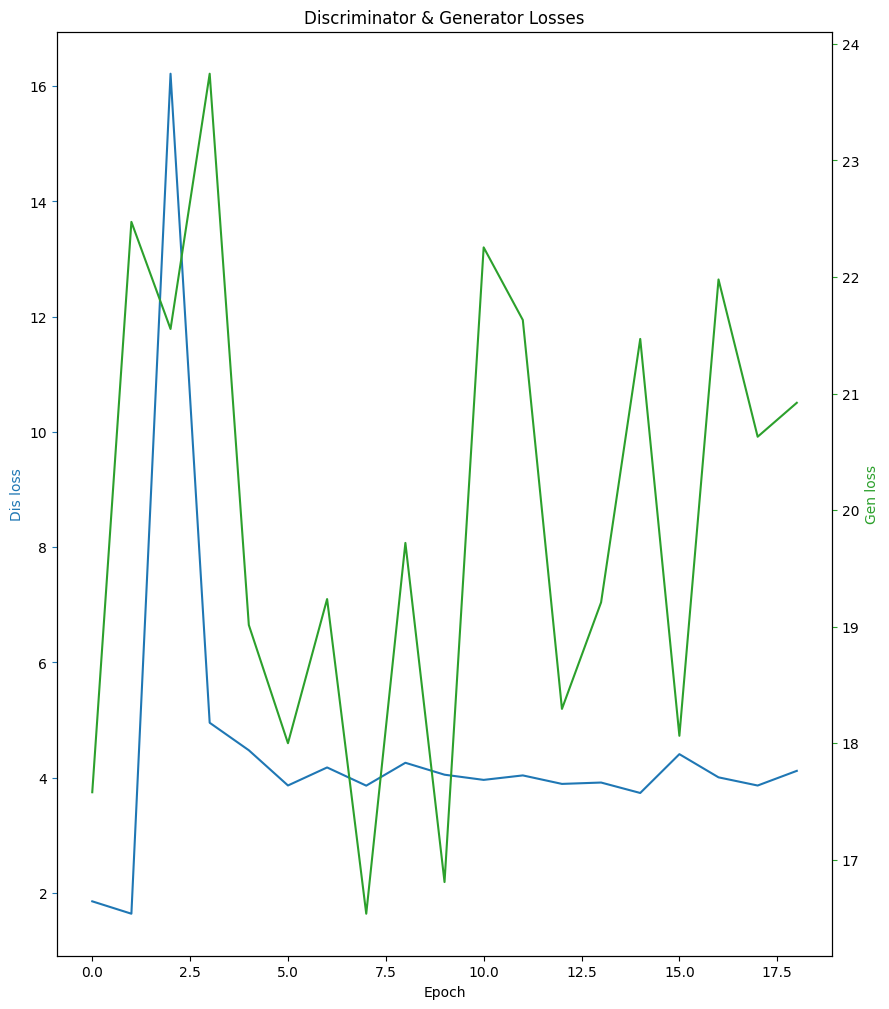


 3.520634174346924 21.27983856201172
--------------- Epoch 21 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 3.624105453491211 19.731853485107422
--------------- Epoch 22 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step

 4.047905445098877 18.450374603271484
--------------- Epoch 23 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 3.694892168045044 17.681203842163086
--------------- Epoch 24 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step

 3.611814498901367 16.088573455810547
--------------- Epoch 25 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step

 4.015697956085205 18.493200302124023
--------------- Epoch 26 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step

 3.800158977508545 18.4366512298584
--------------- Epoch 27 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step

 3.958016872406006 14.805130958557129
--------------- Epoch 28 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step

 3.7509682178497314 16.679729461669922
--------------- Epoch 29 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

 3.4977877140045166 14.740744590759277
--------------- Epoch 30 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 3.748366117477417 17.868364334106445
--------------- Epoch 31 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step

 3.7139840126037598 21.3072509765625
--------------- Epoch 32 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 3.214240550994873 15.903454780578613
--------------- Epoch 33 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 3.8768250942230225 18.62274169921875
--------------- Epoch 34 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 3.169130802154541 18.041851043701172
--------------- Epoch 35 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 3.5746991634368896 17.147523880004883
--------------- Epoch 36 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step

 3.4722800254821777 15.548218727111816
--------------- Epoch 37 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step

 3.675813913345337 20.315217971801758
--------------- Epoch 38 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step

 3.4156973361968994 14.290865898132324
--------------- Epoch 39 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step

 3.569239616394043 16.969768524169922
--------------- Epoch 40 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


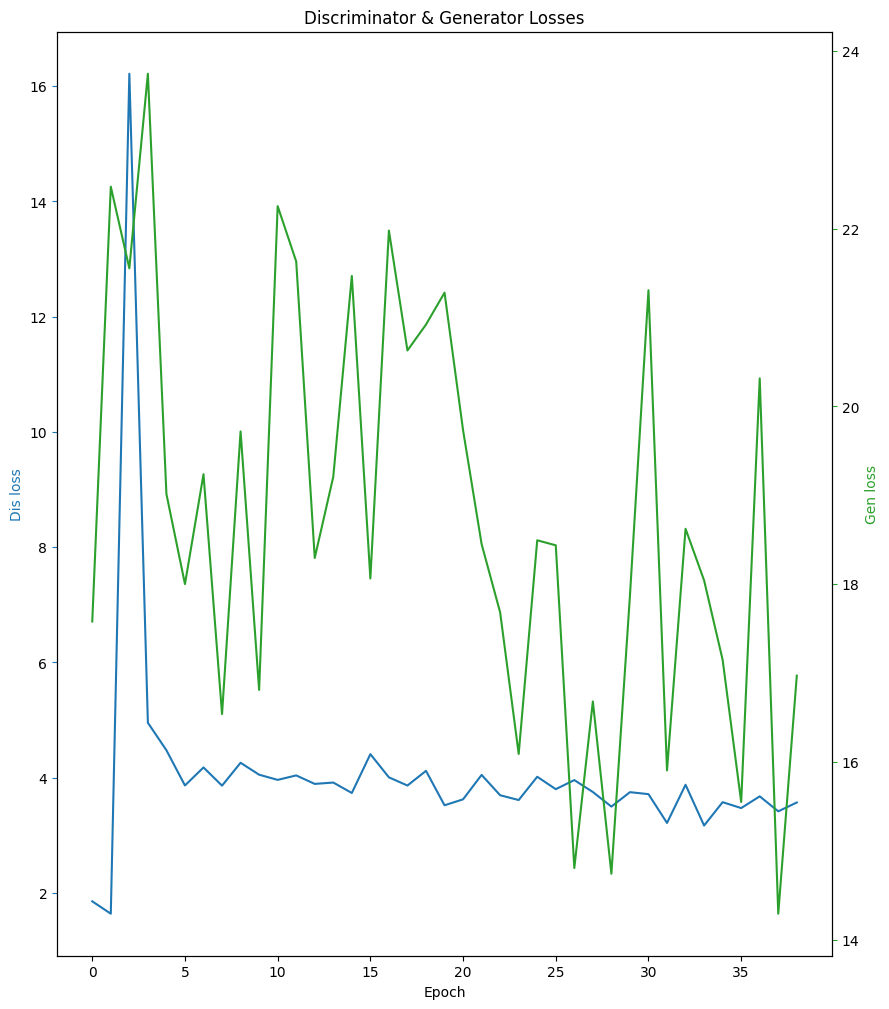


 3.076643228530884 17.441062927246094
--------------- Epoch 41 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step

 3.5117149353027344 15.26548957824707
--------------- Epoch 42 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step

 3.571876049041748 16.44144630432129
--------------- Epoch 43 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 3.805299997329712 18.275983810424805
--------------- Epoch 44 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 3.5538430213928223 17.743051528930664
--------------- Epoch 45 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step

 3.114921808242798 17.40438461303711
--------------- Epoch 46 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step

 3.6488242149353027 16.2633113861084
--------------- Epoch 47 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step

 5.788769721984863 16.828115463256836
--------------- Epoch 48 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step

 3.899897336959839 18.051937103271484
--------------- Epoch 49 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step

 3.680647134780884 16.633668899536133
--------------- Epoch 50 ---------------


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step

 4.093133926391602 15.536327362060547


In [32]:
model_srgan.srgan.load_weights('srgan_weights_epoch_50.h5')
model_srgan.train(50, save_interval=20 ,batch_size=16)

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 44ms/step


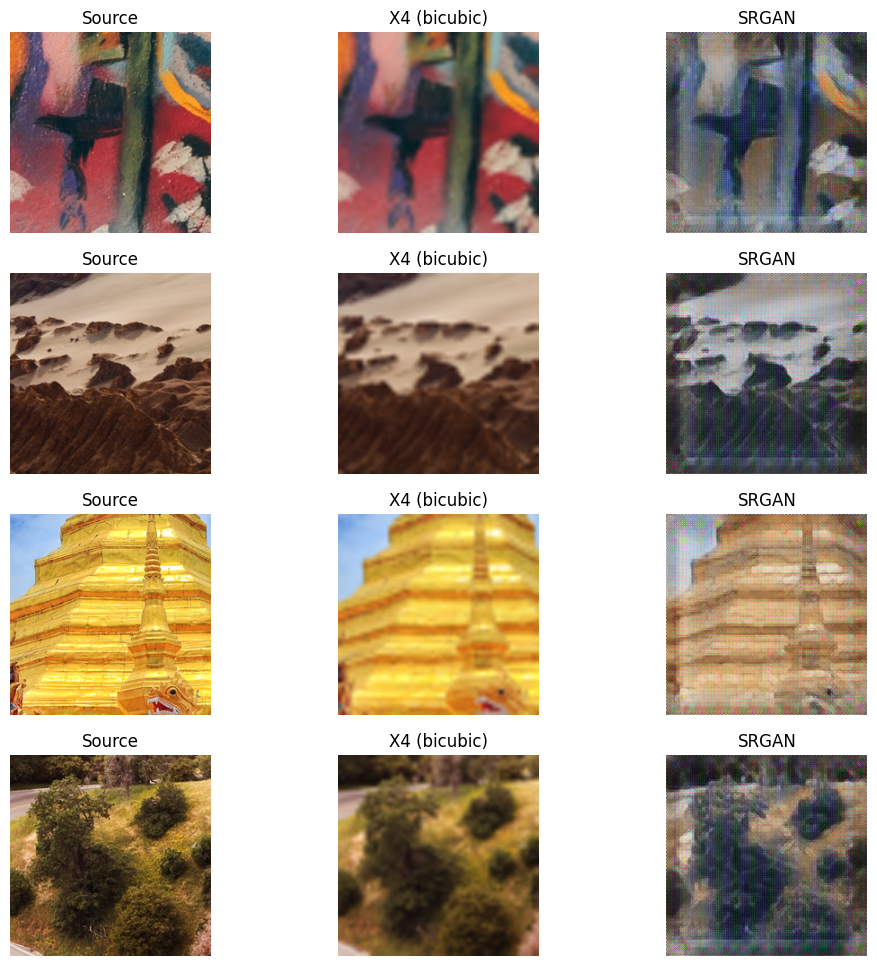

In [33]:
# Load pretrained model
model_srgan.srgan.load_weights('srgan_weights_epoch_50.h5')
plot_predict(low_reso_imgs,high_reso_imgs,model_srgan)